In [39]:
#Import Necessary Library's
import pandas as pd
import numpy as np
import re
import json
import folium
from pathlib import Path
import seaborn as sn
import matplotlib.pyplot as pyplot

In [40]:
#Set up file path
data_folder = Path("./Data/")

In [41]:
HappinessFile = data_folder / "2019 Happiness Data.csv"

#Import Data to Pandas DataFrame
happinessDF = pd.read_csv(HappinessFile)
happinessDF2 = happinessDF.drop(happinessDF.columns.difference(["Country or region", "Score"]), axis = 1)
happinessDF2.rename(columns = {"Score": "Happiness Score", "Country or region": "Country Name"}, inplace = True)
happinessDF2.set_index("Country Name", inplace = True)

In [42]:
#Import Data
FreedomFile = data_folder / "economic_freedom_index2019_data.csv"

#Import Data to Pandas DataFrame
economicFreedomDF = pd.read_csv(FreedomFile,encoding='latin-1')
economicFreedomDF = economicFreedomDF.dropna(subset=["World Rank"])
economicFreedomDF2 = economicFreedomDF.drop(economicFreedomDF.columns.difference(["Country Name","2019 Score","Financial Freedom", "Population (Millions)", "Unemployment (%)", "Inflation (%)"]), axis = 1)
economicFreedomDF2.rename(columns = {"2019 Score": "Economic Freedom"}, inplace = True)
economicFreedomDF2.set_index("Country Name", inplace = True)

In [43]:
#Import Data
GDPData = data_folder / "GDPfinal.json"

# read in json file of GDP data 
GDPDF = pd.read_json(GDPData)

GDPDF2 = GDPDF.drop(GDPDF.columns.difference(["Country","Growth Rate", "GDP (IMF)", "GDP Per Capita"]), 1)
GDPDF2.drop(GDPDF2.index[GDPDF2["GDP (IMF)"] == "-"], inplace=True)
GDPDF2.dropna(subset=["Growth Rate"], inplace = True)
GDPDF2.rename(columns = {"GDP (IMF)": "GDP (Billions)", "Country": "Country Name"}, inplace = True)
GDPDF2.set_index("Country Name", inplace = True)

for rowlabel, rowseries in GDPDF2.iterrows():
    GDPDF2.loc[rowlabel, "GDP Per Capita"] = float(re.sub("[^0-9.]", "", GDPDF2.loc[rowlabel, "GDP Per Capita"]))
    GDPDF2.loc[rowlabel, "Growth Rate"] = float(re.sub("[^0-9.]", "", GDPDF2.loc[rowlabel, "Growth Rate"]))
    
    gdp = GDPDF2.loc[rowlabel, "GDP (Billions)"]
    gdpMag = gdp[-2:]
    gdpClean = float(re.sub("[^0-9.]", "", gdp))
    
    if gdpMag == "Tn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean * 1000
    elif gdpMag == "Bn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean
    elif gdpMag == "Mn":
        GDPDF2.loc[rowlabel, "GDP (Billions)"] = gdpClean/1000

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


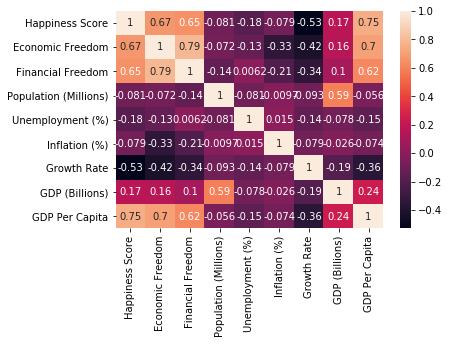

In [44]:
df = happinessDF2.join(economicFreedomDF2, on = 'Country Name', how = "inner")
df_final = df.join(GDPDF2, on = 'Country Name', how = "inner")
df_final = df_final.astype(float)
corrMatrix = df_final.corr(method = "pearson")
sn.heatmap(corrMatrix, annot=True)
pyplot.show()

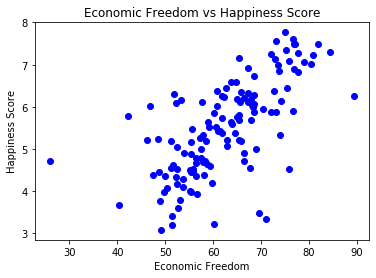

In [45]:
pyplot.plot(df_final["Economic Freedom"],df_final["Happiness Score"], "bo")
pyplot.xlabel("Economic Freedom")
pyplot.ylabel("Happiness Score")
pyplot.title("Economic Freedom vs Happiness Score")
pyplot.show()

In [46]:
x = df_final["Economic Freedom"]
y = df_final["Happiness Score"]

A = np.vstack([x, np.ones(len(x))]).T

In [47]:
model, SSE = np.linalg.lstsq(A, y, rcond=None)[:2]

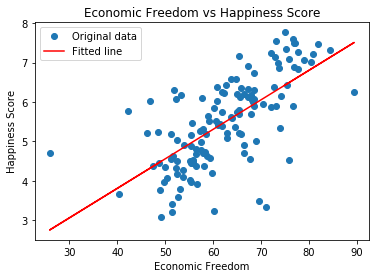

In [48]:
_ = pyplot.plot(x, y, 'o', label='Original data')
_ = pyplot.plot(x, model[0]*x + model[1], 'r', label='Fitted line')
_ = pyplot.xlabel("Economic Freedom")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("Economic Freedom vs Happiness Score")
_ = pyplot.legend()
pyplot.show()

In [49]:
#Find R^2 of model
rSquare2 = 1 - SSE[0] / sum((y - y.mean())**2) 
rSquare2

0.45229802223883775

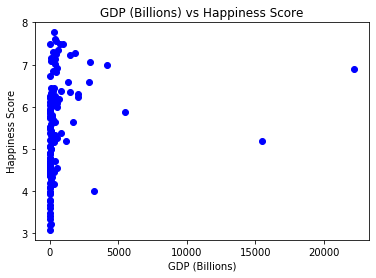

In [50]:
#Second Model
pyplot.plot(df_final["GDP (Billions)"],df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("GDP (Billions)")
pyplot.ylabel("Happiness Score")
pyplot.title("GDP (Billions) vs Happiness Score")
pyplot.show()

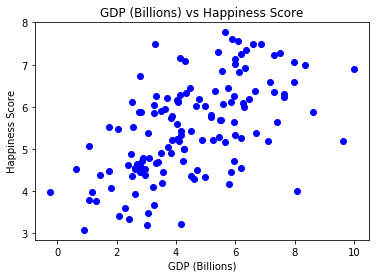

In [51]:
#Transform GDP Billions
pyplot.plot(np.log(df_final["GDP (Billions)"]),df_final["Happiness Score"], "bo") #Covers several orders of magnitude
pyplot.xlabel("GDP (Billions)")
pyplot.ylabel("Happiness Score")
pyplot.title("GDP (Billions) vs Happiness Score")
pyplot.show()

In [52]:
x2 = np.log(df_final["GDP (Billions)"])
y2 = df_final["Happiness Score"]

A2 = np.vstack([x2, np.ones(len(x2))]).T

In [53]:
model2, SSE2 = np.linalg.lstsq(A2, y2, rcond=None)[:2]

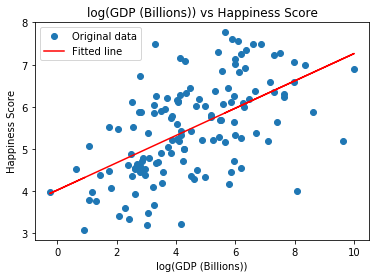

In [54]:
_ = pyplot.plot(x2, y2, 'o', label='Original data')
_ = pyplot.plot(x2, model2[0]*x2 + model2[1], 'r', label='Fitted line')
_ = pyplot.xlabel("log(GDP (Billions))")
_ = pyplot.ylabel("Happiness Score")
_ = pyplot.title("log(GDP (Billions)) vs Happiness Score")
_ = pyplot.legend()
pyplot.show()


##### Have to take the log of whatever you predict

In [55]:
#Finding R^2 for second model
rSquare2 = 1 - SSE2[0] / sum((y2 - y2.mean())**2) 
rSquare2

0.3190029292906227

Below is the old way we were importing data. Keeping it in case new way does not work.

In [56]:
json_file = open(data_folder / "countries.geo.json", "r")
countries_geojson = json.load(json_file)

In [57]:
countries_from_geojson = []
for item in countries_geojson["features"]:
    countries_from_geojson.append(item.get("properties", {}).get("name"))

In [58]:
countries_geojson["features"][0]

{'type': 'Feature',
 'id': 'AFG',
 'properties': {'name': 'Afghanistan'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[61.210817, 35.650072],
    [62.230651, 35.270664],
    [62.984662, 35.404041],
    [63.193538, 35.857166],
    [63.982896, 36.007957],
    [64.546479, 36.312073],
    [64.746105, 37.111818],
    [65.588948, 37.305217],
    [65.745631, 37.661164],
    [66.217385, 37.39379],
    [66.518607, 37.362784],
    [67.075782, 37.356144],
    [67.83, 37.144994],
    [68.135562, 37.023115],
    [68.859446, 37.344336],
    [69.196273, 37.151144],
    [69.518785, 37.608997],
    [70.116578, 37.588223],
    [70.270574, 37.735165],
    [70.376304, 38.138396],
    [70.806821, 38.486282],
    [71.348131, 38.258905],
    [71.239404, 37.953265],
    [71.541918, 37.905774],
    [71.448693, 37.065645],
    [71.844638, 36.738171],
    [72.193041, 36.948288],
    [72.63689, 37.047558],
    [73.260056, 37.495257],
    [73.948696, 37.421566],
    [74.980002, 37.41999],
    [75.158028, 3

In [59]:
print(sorted(countries_from_geojson))

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Southern and Antarctic Lands', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guatemala', 'Guinea', 'Guinea Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory 

In [60]:
# checking which countries are not in geojson
for _item in happinessDF['Country or region'].unique():
    if _item not in countries_from_geojson:
        print(_item)
        
# United States, Trinidad & Tobago, North Macedonia, and Congo (Kinshasa) need to be renamed
# Sinapore, Bahrain, Mauritus, Serbia, Hong Kong, Palestinian Territories, Congo (Brazzaville), and Tanzania need to be removed

United States
Singapore
Bahrain
Trinidad & Tobago
Mauritius
Serbia
Hong Kong
North Macedonia
Congo (Brazzaville)
Palestinian Territories
Congo (Kinshasa)
Comoros
Tanzania


In [61]:
happinessDF1 = happinessDF.replace({"United States": "United States of America", "Trinidad & Tobago": "Trinidad and Tobago", "North Macedonia": "Macedonia", 
"Congo (Kinshasa)": "Democratic Republic of the Congo"})

In [62]:
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Singapore']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Bahrain']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Mauritius']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Serbia']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Hong Kong']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Palestinian Territories']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Congo (Brazzaville)']
happinessDF1 = happinessDF1[happinessDF1['Country or region'] != 'Tanzania']

In [63]:
country_df = happinessDF1[['Country or region', 'Score']]
country_df = country_df.rename(columns={"Country or region": "Name"})
country_df.head()

,Name,Score
0,Finland,7.769
1,Denmark,7.600
2,Norway,7.554
3,Iceland,7.494
4,Netherlands,7.488


In [68]:
for item in countries_geojson["features"]:
    key = item.get("properties", {}).get("name")
    score = re.findall(r'(\d\.\d+)|$', str(country_df[country_df['Name']==key]['Score']))[0]
    content = f"Name: {key} | Happiness Score: {str(score)}"
    item['properties']['content'] = content

In [69]:
df_map = folium.Map(
    location=[0,0],
    zoom_start=3
)

tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(df_map)


choropleth = folium.Choropleth(
    geo_data=countries_geojson,
    key_on='feature.properties.name',
    data=country_df, 
    columns=['Name', 'Score'], 
    fill_color='PuBuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    legend_name="Happiness Score"
).add_to(df_map)

folium.LayerControl().add_to(df_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['content'], labels=False,
                                   style=('background-color: grey; color: white;'))
)

df_map